### Ribosome ramp

Improved Ribosome-Footprint and mRNA Measurements Provide Insights into Dynamics and Regulation of Yeast Translation

http://www.cell.com/cell-reports/abstract/S2211-1247(16)30021-3

In [1]:
import cPickle as pkl
import numpy as np
import pandas as pd
import shelve
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

6713

In [2]:
#filepath_general = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"
#filepath_polysomes = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"

filepath_general = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160810_1513_1800s.p"
filepath_polysomes = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20160810_1513.db"

Regular results:

Make file readable by ipython in case it was created by pypy:

In [3]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path, 'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)
    
#replace(filepath_general, "_numpypy.multiarray", "numpy.core.multiarray")

In [4]:
results = pkl.load(open(filepath_general))

In [5]:
print results.keys()

['n_tRNA', 'description', 'n_ribosomes', 'timerange', 'proteome', 'transcriptome', 'duration', 'time_stamp', 'timecourses']


Detailed results/ribosome timecourses:

In [6]:
d = shelve.open(filepath_polysomes)

Generate the ribosome lattice dict (for every gene the total of ribos at all positions):

In [7]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

In [8]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [9]:
pd.Series(avg_ribos_per_gene).describe()

count    4475.000000
mean        0.124851
std         0.626385
min         0.000000
25%         0.006701
50%         0.017291
75%         0.051025
max        14.365248
dtype: float64

Check by means of an example:

In [10]:
print sum(ribo_lattice_dict['YIL140W'])*1.0/len(ribo_lattice_dict['YIL140W'])
print avg_ribos_per_gene['YIL140W']
print np.mean(ribo_lattice_dict['YIL140W'])

0.00970873786408
0.00970873786408
0.00970873786408


#### Analysis of all genes (no count restriction)

Define Weinberg's z (eq. S7):

In [11]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

Test of z:

In [12]:
sum([sum(z[gene]) for gene in z])

2278366.0

In [14]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

Artificially restrict ribo_lattice_dict (for testing):

In [15]:
# ribo_lattice_dict = {key: ribo_lattice_dict[key] for key in ribo_lattice_dict if key in orf_lengths}

Excess ribosome densities:

In [16]:
max_length = max([len(ribo_lattice_dict[gene]) for gene in ribo_lattice_dict])
print max_length

4911


In [17]:
import math

excess = []

for pos in range(max_length):
    
    numer = sum([z[gene][pos] for gene in z if len(ribo_lattice_dict[gene]) > pos])
    denom = sum([1.0          for gene in z if len(ribo_lattice_dict[gene]) > pos])
    # denom = sum([1 if len(ribo_lattice_dict[gene]) > pos else 0 for gene in z]) * 1.0 # daran liegt's nicht
    excess.append(numer / denom)
excess = np.array(excess)

In [18]:
print sum(excess)

5433.690733


Testing code from previous notebook:

In [19]:
import math

e = []
for j in range(4911):
    numer = 0.0
    denom = 0.0
    for gene in z:
        if orf_lengths[gene]/3 > j:
            if not math.isnan(z[gene][j]):
                numer += z[gene][j]
                denom += 1
        #  denom = sum([1 if orf_lengths[gene] >= j else 0 for gene in ribo_lattice_dict]) * 1.0
    e.append(numer/denom)

In [20]:
sum(e)

5433.690733004727

Seem to have found the problem; to be continued.

In [21]:
normalization = sum(excess[449:500]) / 51.0
print normalization

1.04781186509


In [22]:
relative_excess = excess / normalization

/home/martin/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=25,center=False).mean()


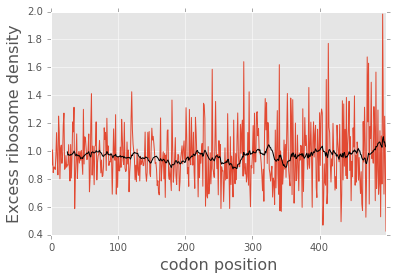

In [23]:
plt.plot(relative_excess[:500])
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(relative_excess[:500]), 25).plot(style='k')

### Restriction to subset of genes

We look at the distribution of ribosomes per ORF before we restrict. 

In [24]:
ribo_total_dict = {gene: sum(ribo_lattice_dict[gene]) 
                   for gene in ribo_lattice_dict}

In [25]:
pd.Series(ribo_total_dict.values()).describe()

count    4475.000000
mean       37.403352
std       201.084458
min         0.000000
25%         3.000000
50%         8.000000
75%        20.000000
max      8102.000000
dtype: float64

In [26]:
len(ribo_total_dict) * np.mean(ribo_total_dict.values())

167380.0

This is approximately the expected number of bound ribosomes (81% of 200000).

In [27]:
critical_count = 128

Weinberg et al. use 128, this would yield 216 genes.

In [28]:
len([gene for gene in ribo_total_dict 
     if ribo_total_dict[gene] >= critical_count])

217

Filter only genes above critical count:

In [29]:
ribo_lattice_dict = {gene: ribo_lattice_dict[gene] for gene in 
                     ribo_lattice_dict if ribo_total_dict[gene] >= 
                     critical_count}

In [30]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [31]:
pd.Series(avg_ribos_per_gene.values()).describe()

count    217.000000
mean       1.761030
std        2.273229
min        0.059646
25%        0.332231
50%        0.636943
75%        2.719626
max       14.365248
dtype: float64

In [32]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

In [33]:
max_length = max([len(ribo_lattice_dict[gene]) for gene in ribo_lattice_dict])
print max_length

2673


In [34]:
import math

excess = []

for pos in range(max_length):
    
    numer = sum([z[gene][pos] for gene in z if len(ribo_lattice_dict[gene]) > pos])
    denom = sum([1.0          for gene in z if len(ribo_lattice_dict[gene]) > pos])
    # denom = sum([1 if len(ribo_lattice_dict[gene]) > pos else 0 for gene in z]) * 1.0 # daran liegt's nicht
    excess.append(numer / denom)
excess = np.array(excess)

In [35]:
print sum(excess)

2574.88339298


In [36]:
normalization = sum(excess[449:500]) / 51.0
print normalization

1.00500383572


In [37]:
relative_excess = excess / normalization

/home/martin/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=25,center=False).mean()


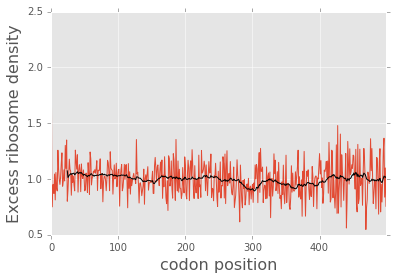

In [38]:
plt.plot(relative_excess[:500])
plt.xlabel('codon position', fontsize=16)
plt.ylabel('Excess ribosome density', fontsize=16)
pd.rolling_mean(pd.Series(relative_excess[:500]), 25).plot(style='k')

The ribosome ramp has disappeared.

### Codon distribution hypothesis

In [3]:
def chunker(seq, size):
    '''
    generator that takes a sequence and returns substrings of given size
    '''
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

We can do it two ways:

1. Weighted by transcript abundance
2. All genes equally weighted

#### 1. Weighted by transcript abundance

Longest and shortest gene in codons:

In [4]:
print max(len(orf_genomic_dict[gene]) for gene in orf_genomic_dict) / 3.0
print min(len(orf_genomic_dict[gene]) for gene in orf_genomic_dict) / 3.0

4911.0
17.0


The following two are not divisible by 3 (weird, pseudogenes):

In [5]:
if 'YAR061W' in orf_genomic_dict:
    del orf_genomic_dict['YAR061W']
if 'YFL056C' in orf_genomic_dict:
    del orf_genomic_dict['YFL056C']

In [6]:
codon_anticodon = {
    'uuu': 'gaa', 'ucu': 'aga', 'uau': 'gua', 'ugu': 'gca',
    'uuc': 'gaa', 'ucc': 'aga', 'uac': 'gua', 'ugc': 'gca',
    'uua': 'uaa', 'uca': 'uga', 'uaa': '*', 'uga': '*',  # '*'==stop
    'uug': 'caa', 'ucg': 'cga', 'uag': '*', 'ugg': 'cca',
    'cuu': 'gag', 'ccu': 'agg', 'cau': 'gug', 'cgu': 'acg',
    'cuc': 'gag', 'ccc': 'agg', 'cac': 'gug', 'cgc': 'acg',
    'cua': 'uag', 'cca': 'ugg', 'caa': 'uug', 'cga': 'acg',
    'cug': 'uag', 'ccg': 'ugg', 'cag': 'cug', 'cgg': 'ccg',
    'auu': 'aau', 'acu': 'agu', 'aau': 'guu', 'agu': 'gcu',
    'auc': 'aau', 'acc': 'agu', 'aac': 'guu', 'agc': 'gcu',
    'aua': 'uau', 'aca': 'ugu', 'aaa': 'uuu', 'aga': 'ucu',
    'aug': 'cau', 'acg': 'cgu', 'aag': 'cuu', 'agg': 'ccu',
    'guu': 'aac', 'gcu': 'agc', 'gau': 'guc', 'ggu': 'gcc',
    'guc': 'aac', 'gcc': 'agc', 'gac': 'guc', 'ggc': 'gcc',
    'gua': 'uac', 'gca': 'ugc', 'gaa': 'uuc', 'gga': 'ucc',
    'gug': 'cac', 'gcg': 'ugc', 'gag': 'cuc', 'ggg': 'ucc'
}

TO BE CONTINUED

#### 2. All genes equally weighted

In [7]:
codon_counter_df = pd.DataFrame(index=range(1, 4912), columns=sorted(codon_anticodon.keys()))
codon_counter_df.fillna(0, inplace=True)

anticodon_counter_df = pd.DataFrame(index=range(1, 4912), columns=sorted(list(set(codon_anticodon.values()))))
anticodon_counter_df.fillna(0, inplace=True)

for i, gene in enumerate(orf_genomic_dict):
    codons = list(chunker(orf_genomic_dict[gene], 3))
    anticodons = [codon_anticodon[codon] for codon in codons]
    # print list(anticodons)
    if not i%100:
        print i,
    for pos, codon in enumerate(codons):
        codon_counter_df[codon][pos+1] += 1
    for pos, anticodon in enumerate(list(anticodons)):
        anticodon_counter_df[anticodon][pos+1] += 1

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700


In [8]:
pkl.dump(codon_counter_df, open("../data/codon_counter_df.p", "wb"))
pkl.dump(anticodon_counter_df, open("../data/anticodon_counter_df.p", "wb"))

In [9]:
anticodon_counter_sel = anticodon_counter_df.loc[range(1, 501, 10)]
anticodon_counter_sel = anticodon_counter_sel #/ anticodon_counter_sel.sum(axis=1).transpose()

In [10]:
anticodon_counter_sel.div(anticodon_counter_sel.sum(axis=1), axis=0).head()

,*,aac,aau,acg,aga,agc,agg,agu,caa,cac,...,uau,ucc,ucu,uga,ugc,ugg,ugu,uuc,uug,uuu
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.034123,0.037699,0.017583,0.037848,0.042766,0.026673,0.030398,0.023245,0.012368,...,0.023096,0.019818,0.023394,0.021010,0.025481,0.025779,0.016987,0.031441,0.024885,0.037103
21,0.000000,0.041133,0.043666,0.014307,0.040984,0.039940,0.023398,0.040537,0.020417,0.016095,...,0.017735,0.020715,0.020566,0.023547,0.023547,0.024590,0.021610,0.035171,0.025037,0.038152
31,0.001048,0.030983,0.039216,0.018111,0.038168,0.033378,0.022003,0.034725,0.023350,0.009430,...,0.020656,0.017363,0.020057,0.021703,0.023799,0.029786,0.018710,0.037420,0.029337,0.036372
41,0.000603,0.028054,0.042534,0.012821,0.042685,0.034992,0.018401,0.031674,0.024736,0.010407,...,0.017345,0.017345,0.019005,0.022021,0.023529,0.029110,0.018401,0.044796,0.034992,0.040271


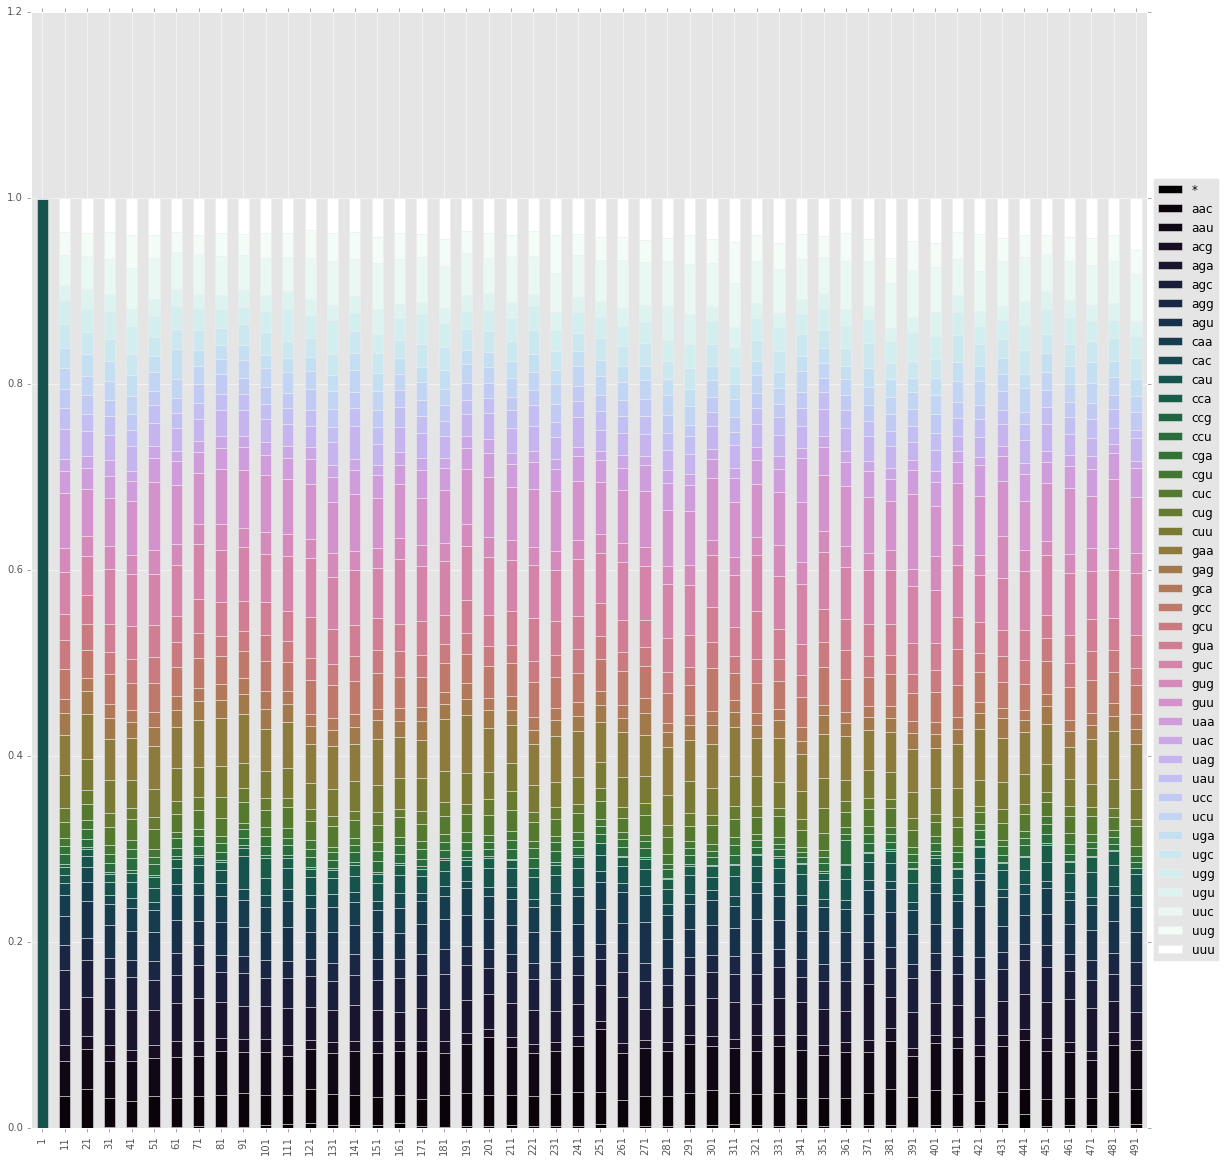

In [11]:
anticodon_counter_sel.div(anticodon_counter_sel.sum(axis=1), 
                          axis=0).plot(kind='bar', stacked=True, figsize=(20, 20), colormap='cubehelix')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Get data from https://github.com/gittenberg/TRSL/blob/master/workbooks/TRSL_check_observables.ipynb:

In [14]:
import collections as col
counter = col.OrderedDict([('ccg', 143),
             ('cca', 158),
             ('ucu', 175),
             ('acg', 221),
             ('cuu', 240),
             ('ugg', 250),
             ('caa', 259),
             ('gcc', 278),
             ('aac', 281),
             ('agu', 319),
             ('agc', 336),
             ('uug', 344),
             ('uuc', 353),
             ('uaa', 365),
             ('gca', 366),
             ('gug', 374),
             ('cau', 380),
             ('aga', 388),
             ('ugu', 434),
             ('aau', 442),
             ('ugc', 476),
             ('cac', 481),
             ('gua', 494),
             ('uac', 540),
             ('uga', 555),
             ('gaa', 566),
             ('guc', 585),
             ('ucc', 606),
             ('uuu', 621),
             ('cgu', 746),
             ('uau', 793),
             ('cga', 808),
             ('ccu', 859),
             ('guu', 890),
             ('cuc', 928),
             ('uag', 943),
             ('gcu', 948),
             ('cug', 1090),
             ('agg', 1103),
             ('gag', 2360)])

The eleven slowest codons:

In [20]:
counter.keys()[-11:]

['cgu', 'uau', 'cga', 'ccu', 'guu', 'cuc', 'uag', 'gcu', 'cug', 'agg', 'gag']